In [56]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Data preparation

In [57]:
df= pd.read_csv("walmart_cleaned.csv")
df.head()

Unnamed: 0  Store        Date  IsHoliday  Dept  Weekly_Sales  Temperature  \
0           0      1  2010-02-05          0   1.0      24924.50        42.31   
1           1      1  2010-02-05          0  26.0      11737.12        42.31   
2           2      1  2010-02-05          0  17.0      13223.76        42.31   
3           3      1  2010-02-05          0  45.0         37.44        42.31   
4           4      1  2010-02-05          0  28.0       1085.29        42.31   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        0.0        0.0        0.0        0.0        0.0   
1       2.572        0.0        0.0        0.0        0.0        0.0   
2       2.572        0.0        0.0        0.0        0.0        0.0   
3       2.572        0.0        0.0        0.0        0.0        0.0   
4       2.572        0.0        0.0        0.0        0.0        0.0   

          CPI  Unemployment  Type    Size  
0  211.096358         8.106     3  151315  
1  211.096358         8.106     3  151315  
2  211.096358         8.106     3  151315  
3  211.096358         8.106     3  151315  
4  211.096358         8.106     3  151315

In [58]:
data1=df.drop(['Unnamed: 0','Date'],axis=1)
data1.head()

Store  IsHoliday  Dept  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  \
0      1          0   1.0      24924.50        42.31       2.572        0.0   
1      1          0  26.0      11737.12        42.31       2.572        0.0   
2      1          0  17.0      13223.76        42.31       2.572        0.0   
3      1          0  45.0         37.44        42.31       2.572        0.0   
4      1          0  28.0       1085.29        42.31       2.572        0.0   

   MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  Type  \
0        0.0        0.0        0.0        0.0  211.096358         8.106     3   
1        0.0        0.0        0.0        0.0  211.096358         8.106     3   
2        0.0        0.0        0.0        0.0  211.096358         8.106     3   
3        0.0        0.0        0.0        0.0  211.096358         8.106     3   
4        0.0        0.0        0.0        0.0  211.096358         8.106     3   

     Size  
0  151315  
1  151315  
2  151315  
3  151315  
4  151315

# Target setting

In [59]:
m=len(data1)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

target=['Weekly_Sales']
dataY=data1[target]
dataX=data1.drop(target,axis=1)

df_columns = list(dataX.columns)
print(df_columns)



['Store', 'IsHoliday', 'Dept', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']


In [75]:
trainX=dataX.iloc[M[0:(m//4)*3]]
trainY=dataY.iloc[M[0:(m//4)*3]]
testX=dataX.iloc[M[(m//4)*3:]]
testY=dataY.iloc[M[(m//4)*3:]]

train_df=trainX
test_df=testX

train_df.columns=df_columns
test_df.columns=df_columns

def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [61]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [76]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [77]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

100%|██████████| 1/1 [00:00<00:00, 13.57it/s]


createcreate_numeric_feature  0.060[s]


100%|██████████| 1/1 [00:00<00:00, 42.48it/s]

createcreate_numeric_feature  0.018[s]


In [64]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float64)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    callbacks=[
                    lgbm.early_stopping(stopping_rounds=100) , # Early stopping callback 
                    lgbm.log_evaluation(period=verbose)]
                    )

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5 #to calculate the RMSE
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [65]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [66]:
y = trainY
ydf=pd.DataFrame(y)
ydf

Weekly_Sales
353300       8724.37
187781      28681.98
129100       8845.17
53186        9313.13
56896          84.68
...              ...
136133      10887.55
63322       13155.08
314043       2424.13
178566      11040.83
243169      30146.00

[316176 rows x 1 columns]

In [ ]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2458
[LightGBM] [Info] Number of data points in the train set: 252940, number of used features: 14
[LightGBM] [Info] Start training from score 16004.129218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

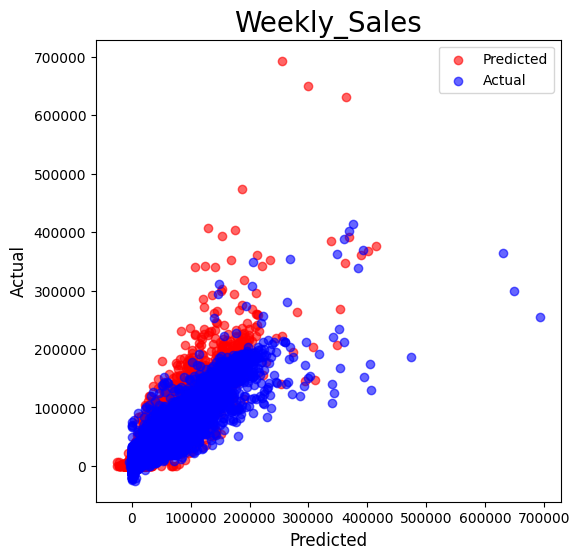

In [68]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title(target[i], fontsize=20)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)

# Plot predicted values in one color
ax.scatter(oof, y, color="red", alpha=0.6, label="Predicted")

# Plot actual values in another color
ax.scatter(y, oof, color="blue", alpha=0.6, label="Actual")

# Add legend to distinguish between the two
ax.legend()

plt.show()

# Visulization importance

In [69]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2458
[LightGBM] [Info] Number of data points in the train set: 252940, number of used features: 14
[LightGBM] [Info] Start training from score 16004.129218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

Exception ignored on calling ctypes callback function: <function _log_callback at 0x0000018CA66FF1A0>
Traceback (most recent call last):
  File "c:\Users\pc\Documents\LEVEL 4\data science\project\tensorflow_env\Lib\site-packages\lightgbm\basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

C:\Users\pc\AppData\Local\Temp\ipykernel_16908\3011810601.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=feature_importance_df,


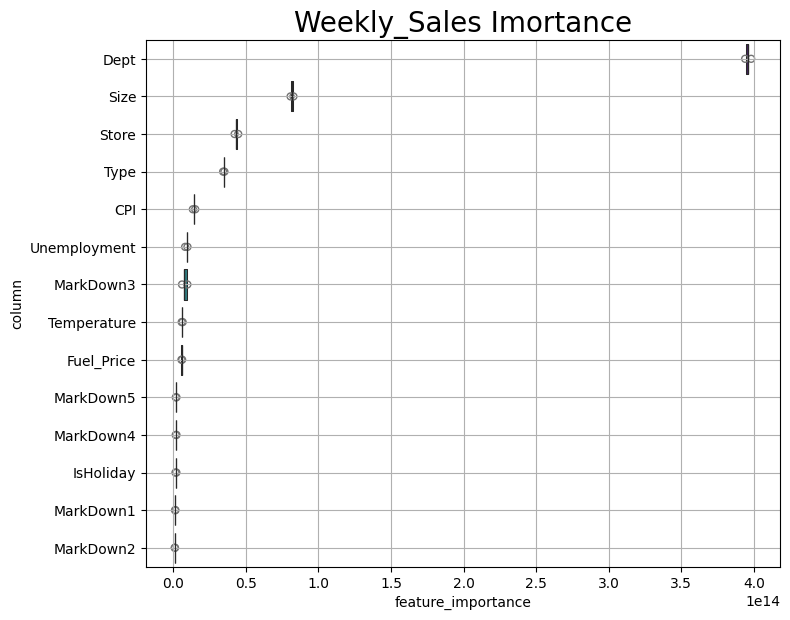

In [ ]:
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Importance',fontsize=20)

In [71]:
preds=[]
for i in range(5):
    preds += [models[i].predict(test_feat_df.values)/5]
predsT=np.array(preds).T
preds2=[]
for item in predsT:
    value=sum(item)
    preds2+=[value]
print(preds2[0:5])

[np.float64(11866.455091501197), np.float64(25190.247908137717), np.float64(1399.1709363449233), np.float64(11767.270077220104), np.float64(20126.57232696363)]


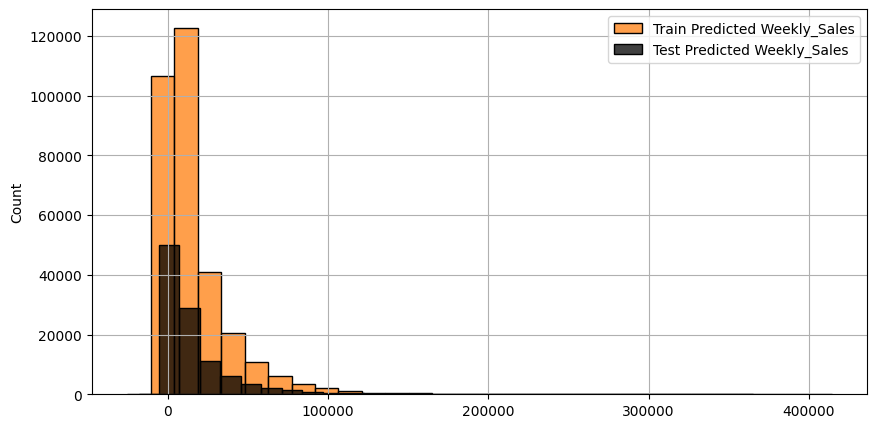

In [72]:
for i in range(1):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(oof, label='Train Predicted '+target[i], ax=ax, color='C1',bins=30)
    sns.histplot(preds2, label='Test Predicted '+target[i], ax=ax, color='black',bins=30)
    ax.legend()
    ax.grid()

# Weekly_Sales VS dept

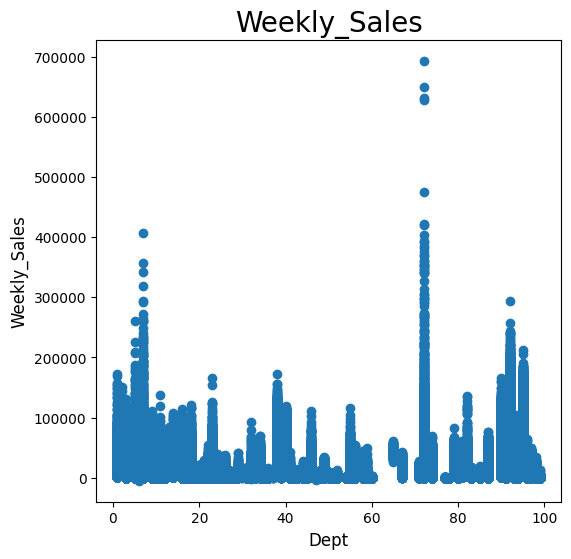

In [73]:
fig,ax = plt.subplots(figsize=(6,6))
ax.set_title(target[i],fontsize=20)
ax.set_xlabel('Dept',fontsize=12)
ax.set_ylabel('Weekly_Sales',fontsize=12)

ax.scatter(df['Dept'],df['Weekly_Sales'])